In [115]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from cm import plot_confusion_matrix

In [2]:
real_codes = pd.read_csv('data/J1939Faults.csv', low_memory = False)
onboard = pd.read_csv('data/VehicleDiagnosticOnboardData.csv', low_memory = False)

# Initial data cleaning and filtering

In [3]:
#Per the project's instructions: 

real_codes = real_codes[real_codes['EquipmentID'].str.len() < 6]
real_codes = real_codes[real_codes['ecuMake'] == 'CMMNS']
real_codes = real_codes[real_codes['active'] == True]

In [4]:
real_codes = real_codes.drop(columns=['actionDescription', 'faultValue', 'MCTNumber'])

In [5]:
#Selects lat and lon coordinates that are not in the bounded boxes

geo_codes = real_codes[(~real_codes['Latitude'].between(36.05942, 36.07392)) | (~real_codes['Longitude'].between(-86.44366, -86.42579))]
geo_codes = geo_codes[(~geo_codes['Latitude'].between(35.58108, 35.59558)) | (~geo_codes['Longitude'].between(-86.4528, -86.435))]
geo_codes = geo_codes[(~geo_codes['Latitude'].between(36.18775, 36.20225)) | (~geo_codes['Longitude'].between(-83.1837, -83.1658))]

#Here is an alternative method for selecting lats and lons that are not in the bounded boxes: 

#geo_codes = real_codes.query('(Latitude <= 36.05942 or Latitude >= 36.07392) or (Longitude <= -86.5419 or Longitude >= -86.3275)')


In [6]:
geo_codes = geo_codes.sort_values(["EquipmentID", "EventTimeStamp"], ascending = (False, True))

# Some EDA

In [7]:
#Number of unique trucks in the data

geo_codes.EquipmentID.nunique()

928

In [8]:
geo_codes_select1569 = geo_codes[geo_codes['spn'].isin([1569])]
geo_codes_select5246 = geo_codes[geo_codes['spn'].isin([5246])]

In [9]:
#Number of unique 1569s thrown by the ECUs

geo_codes_select1569['RecordID'].nunique()

4277

In [10]:
#Number of unique 5426s thrown by the ECUs

geo_codes_select5246['RecordID'].nunique()

270

In [11]:
geo_codes.RecordID.nunique(())

200154

In [12]:
#Looking at the names of the metrics that are recorded when the ECU throws a code

geo_codes[geo_codes['RecordID']  == 4246].head(25)

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp
4245,4246,1048627,2015-02-24 13:45:06.000,Low (Severity Low) Catalyst Tank Level,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,1761,17,True,43,R1762,41.254166,-85.088888,2015-02-24 13:45:41.000


In [13]:
geo_codes.eventDescription.value_counts()

Low (Severity Low) Engine Coolant Level                              137206
Low (Severity Medium) Engine Coolant Level                            14676
High (Severity Low) Water In Fuel Indicator                            6992
Condition Exists Engine Protection Torque Derate                       4277
High Voltage (Water In Fuel Indicator)                                 3768
                                                                      ...  
Error in System Catalyst Tank Controller                                  1
Low Voltage (Aftertreatment 1 Purge Air Actuator)                         1
Abnormal Update Rate Engine Wait to Start Lamp                            1
Out of Calibration Catalyst Tank Controller                               1
High Current Engine Exhaust Gas Recirculation (EGR) Valve Control         1
Name: eventDescription, Length: 266, dtype: int64

# More data cleaning and filtering based on prior EDA

In [14]:
geo_codes = geo_codes.drop(columns=['LocationTimeStamp', 'active', 'ecuSource', 'ecuMake', 'ESS_Id'])

In [15]:
#Reorders our columns in a logical and readable way: index types, data types, others

geo_codes = geo_codes.reindex(columns = ['RecordID', 'EquipmentID', 'EventTimeStamp', 'spn', 'fmi', 'spnfmi',
                                         'activeTransitionCount', 'ecuModel', 'ecuSerialNumber', 'ecuSoftwareVersion',
                                         'eventDescription', 'Latitude', 'Longitude'])

In [16]:
#Concats the spn and fmi fields into a single field, then converts them back to an int

geo_codes['spnfmi'] = geo_codes.spn.astype('str').map(str) + geo_codes.fmi.astype('str')
geo_codes['spnfmi'] = geo_codes['spnfmi'].astype('int32')

# Get dummy variables in preperation of logistic regression

In [17]:
geo_codes_spnfmi = pd.get_dummies(geo_codes, columns = ['spnfmi'])

# Convert datatime column for indexing and sorting

In [18]:
geo_codes_spnfmi['EventTimeStamp'] = geo_codes_spnfmi['EventTimeStamp'].astype('datetime64[ns]')

In [19]:
geo_codes_spnfmi['EventTimeStamp'] = pd.to_datetime(geo_codes_spnfmi['EventTimeStamp'], utc = True)

In [20]:
geo_codes_dropped = geo_codes_spnfmi.reset_index()

In [21]:
#List comprehension of columns created from the get_dummies

List = [x for x in geo_codes_dropped.columns if 'spnfmi_' in x]

# Pandas .rolling() to create a cumulative count of spn-fmi combo codes thrown

In [22]:
geo_codes_dropped = geo_codes_dropped.sort_values(['EquipmentID', 'EventTimeStamp']).reset_index(drop = True)

In [23]:
geo_codes_dropped_rolling = geo_codes_dropped.groupby('EquipmentID').rolling(window = "14d", on = 'EventTimeStamp')[List].sum().reset_index()

In [24]:
merge_geo_codes = geo_codes_dropped.merge(geo_codes_dropped_rolling, left_index = True, right_index = True)

In [25]:
merge_geo_codes = merge_geo_codes.rename(columns = {'EquipmentID_x' : 'EquipmentID', 'EventTimeStamp_x' : 'EventTimeStamp'})

In [26]:
merge_geo_codes = merge_geo_codes.loc[:,~merge_geo_codes.columns.str.contains('_x', case=False)]

In [27]:
merge_geo_codes = merge_geo_codes.drop(columns=['index'])

In [28]:
#Saved for future use when coming back and merging onboard

In [29]:
def backfill (df):
    df['flagtime'] = df.loc[df['spnfmi_156931_y'] == 1, 'EventTimeStamp']
    df['flagtime'] = df.flagtime.bfill()
    return df

In [30]:
merge_geo_codes = merge_geo_codes.groupby('EquipmentID').apply(backfill)

In [31]:
merge_geo_codes['deltatime'] = merge_geo_codes['flagtime'] - merge_geo_codes['EventTimeStamp']

In [32]:
merge_geo_codes['targettime'] = merge_geo_codes.deltatime.dt.total_seconds().between(3600, 86400)

In [33]:
merge_geo_codes = merge_geo_codes[~merge_geo_codes['deltatime'].dt.total_seconds().between(-1, 3600)]

In [34]:
merge_geo_codes = merge_geo_codes[merge_geo_codes['spn'] != 5246]

In [35]:
merge_geo_codes

,RecordID,EquipmentID,EventTimeStamp,spn,fmi,activeTransitionCount,ecuModel,ecuSerialNumber,ecuSoftwareVersion,eventDescription,...,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y,flagtime,deltatime,targettime
0,58809,1327,2015-05-19 12:02:55+00:00,3216,9,1,6X1u10D1500000000,79419774,04993120*00001782*082113134117*07700053*I0*BBZ*,Abnormal Update Rate Aftertreatment 1 Intake NOx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
1,65879,1327,2015-05-26 08:11:45+00:00,3216,9,1,6X1u10D1500000000,79419774,04993120*00001782*082113134117*07700053*I0*BBZ*,Abnormal Update Rate Aftertreatment 1 Intake NOx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
2,65939,1327,2015-05-26 08:44:10+00:00,3216,9,1,6X1u10D1500000000,79419774,04993120*00001782*082113134117*07700053*I0*BBZ*,Abnormal Update Rate Aftertreatment 1 Intake NOx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
3,23445,1330,2015-04-15 20:15:00+00:00,3556,2,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,Incorrect Data Aftertreatment Fuel Injector 1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
4,23449,1330,2015-04-15 20:22:10+00:00,3226,4,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,Low Voltage (Aftertreatment 1 Outlet NOx),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200147,1021420,310,2018-06-05 20:09:14+00:00,97,16,2,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,High (Severity Medium) Water In Fuel Indicator,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,23 days 01:54:27,False
200148,1030174,310,2018-06-26 15:49:59+00:00,5394,5,1,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,2 days 06:13:42,False
200151,4246,R1762,2015-02-24 13:45:06+00:00,1761,17,43,6X1u13D1500000000,79751302,05317106*04119044*051914190353*09400015*G1*BDR*,Low (Severity Low) Catalyst Tank Level,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False
200152,4428,R1762,2015-02-24 15:31:17+00:00,1761,18,11,6X1u13D1500000000,79751302,05317106*04119044*051914190353*09400015*G1*BDR*,Low (Severity Medium) Catalyst Tank Level,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT,NaT,False


# Create a modified version of a train test split

In [36]:
#A function that simulates a train test split that keeps time sequences for trucks together, but still allows individual trucks
#to randomly be assigned to training and testing

def train_test_brake (df):
    df = df.sort_values('EventTimeStamp')
    t_len = df.shape[0]
    t_perc80 = int(t_len * 0.8)
    df80 = df.iloc[0 : t_perc80, :]
    df20 = df.iloc[t_perc80 : , :]
    return(df80, df20) 

In [37]:
dataframe_80_20 = merge_geo_codes.groupby('EquipmentID').apply(train_test_brake)

In [38]:
#Creates training dataset

df80 = pd.concat([x[0] for x in dataframe_80_20])

In [39]:
#Creates testing dataset

df20 = pd.concat([x[1] for x in dataframe_80_20])

# Logistic Regression

In [40]:
#predictors = df80.columns.tolist()
bad_predictors = ['RecordID', 'EquipmentID', 'EventTimeStamp', 
                  'spn', 'fmi', 'ecuModel', 'activeTransitionCount',
                  'ecuSerialNumber', 'ecuSoftwareVersion', 
                  'eventDescription', 'Latitude', 'Longitude', 
                  'EquipmentID_y', 'EventTimeStamp_y', 'spnfmi_156931_y', 
                  'flagtime', 'deltatime', 'targettime']

In [41]:
#predictors.remove(bad_predictors)

In [42]:
predictors_train = df80.drop(bad_predictors, axis = 1)
predictors_test = df20.drop(bad_predictors, axis = 1)

In [43]:
#df20 = df20.drop(bad_predictors, axis = 1)

predictors_train

,spnfmi_272_y,spnfmi_274_y,spnfmi_389_y,spnfmi_512_y,spnfmi_513_y,spnfmi_842_y,spnfmi_849_y,spnfmi_912_y,spnfmi_914_y,spnfmi_918_y,...,spnfmi_5209534_y,spnfmi_6553518_y,spnfmi_6553520_y,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Predictors
X_train = predictors_train

X_test = predictors_test

# Target
y_train = df80.targettime

y_test = df20.targettime

In [45]:
logreg = LogisticRegression().fit(X_train, y_train)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
lr_weights = LogisticRegression(class_weight = {0:1, 1:12})

In [47]:
lr_weights.fit(X_train, y_train)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 12})

In [48]:
y_pred = lr_weights.predict(X_test)

In [49]:
accuracy_score(y_test, y_pred)

0.9652634000460087

In [50]:
logreg.coef_

array([[ 1.08256136e-01,  1.67139119e-01,  0.00000000e+00,
        -3.41066747e-02, -5.56023274e-03, -5.48171864e-02,
        -1.51015432e-01,  3.70329293e-01, -3.37400325e-01,
        -7.21091233e-02, -8.07539692e-02, -2.27614348e-01,
        -2.03951029e-01, -1.20647678e-02, -1.72795063e-02,
        -5.79488049e-03, -2.02936364e-02, -2.21549958e-02,
        -7.90909097e-02, -3.89607950e-02,  3.66505707e-01,
        -4.11224252e-02, -2.15803203e-01,  1.81906276e-01,
        -7.98675316e-03, -7.66100985e-02, -3.25766247e-03,
        -4.99031312e-03, -1.09633988e-01, -2.15233252e-02,
        -1.54537474e-02, -1.41034446e-01, -2.49108108e-02,
        -5.40120518e-02, -1.79918422e-01, -1.10367203e-01,
        -1.97256516e-01, -1.45192130e-02,  3.26828365e-01,
        -5.71314008e-02, -2.09984278e-01,  6.93189335e-02,
        -4.58885631e-02, -4.18561289e-02, -2.29219400e-02,
         1.43218348e-02, -3.13257785e-02,  2.54500272e-02,
        -9.25920569e-02, -1.89126863e-03, -5.18096138e-0

In [51]:
logreg.intercept_

array([-4.3976472])

In [52]:
y_pred = logreg.predict(X_test)

In [53]:
y_pred

array([False, False, False, ..., False, False, False])

In [54]:
logreg.predict_proba(X_test)

array([[0.98268923, 0.01731077],
       [0.99090564, 0.00909436],
       [0.98717171, 0.01282829],
       ...,
       [0.98655744, 0.01344256],
       [0.98534636, 0.01465364],
       [0.98890803, 0.01109197]])

In [55]:
confusion_matrix(y_test, y_pred)

array([[38489,    15],
       [  618,     1]], dtype=int64)

C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (0.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[1], xy = (1.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (-0.05, 1.5), va = 'center', 

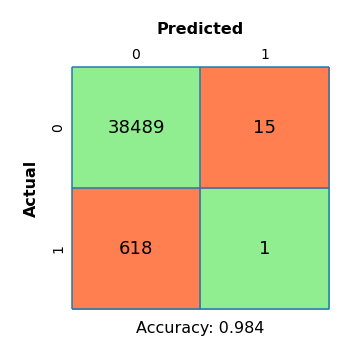

In [56]:
plot_confusion_matrix(y_test, y_pred, labels = ['0', '1'], metric = 'accuracy')

C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (0.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[1], xy = (1.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
C:\Users\alvin\Documents\nss_projects\big_g_express-big_shot\cm.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (-0.05, 1.5), va = 'center', 

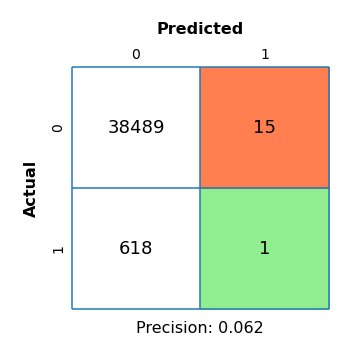

In [57]:
plot_confusion_matrix(y_test, y_pred, labels = ['0', '1'], metric = 'precision')

In [58]:
f1_score(y_test, y_pred, average = 'micro')

0.983820259182578

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     38504
        True       0.06      0.00      0.00       619

    accuracy                           0.98     39123
   macro avg       0.52      0.50      0.50     39123
weighted avg       0.97      0.98      0.98     39123



# *Adjusting and Balancing Unbalanced Classes*

## Class Weights

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [62]:
f1 = make_scorer(f1_score, pos_label = 1)

In [65]:
param_grid = {'class_weight': [{0:1, 1:1}, 
                              {0:1, 1:2},
                              {0:1, 1:5},
                              {0:1, 1:10},
                              {0:1, 1:25},
                              {0:1, 1:50},
                              {0:1, 1:100}]}

In [66]:
lr = LogisticRegression()

In [67]:
gs = GridSearchCV(estimator = lr, 
                  param_grid = param_grid,
                 scoring = f1,
                 cv = 5)

In [68]:
gs.fit(X_train, y_train)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 25}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}]},
             scoring=make_scorer(f1_score, pos_label=1))

In [69]:
gs.best_params_

{'class_weight': {0: 1, 1: 50}}

In [70]:
gs.best_score_

0.0686230927077374

In [71]:
y_pred = gs.predict(X_test)
accuracy_score(y_test, y_pred)

0.9103596349973162

In [72]:
confusion_matrix(y_test, y_pred)

array([[35356,  3148],
       [  359,   260]], dtype=int64)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.92      0.95     38504
        True       0.08      0.42      0.13       619

    accuracy                           0.91     39123
   macro avg       0.53      0.67      0.54     39123
weighted avg       0.98      0.91      0.94     39123



## Undersampling

In [75]:
#!pip install -U imbalanced-learn

In [76]:
from imblearn.under_sampling import RandomUnderSampler

In [77]:
undersampler = RandomUnderSampler(random_state = 321)

In [78]:
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [79]:
y_resampled.value_counts()

False    1184
True     1184
Name: targettime, dtype: int64

In [80]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [81]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8349052986734146

In [82]:
confusion_matrix(y_test, y_pred)

array([[32271,  6233],
       [  226,   393]], dtype=int64)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91     38504
        True       0.06      0.63      0.11       619

    accuracy                           0.83     39123
   macro avg       0.53      0.74      0.51     39123
weighted avg       0.98      0.83      0.90     39123



## Oversampling

In [84]:
from imblearn.over_sampling import RandomOverSampler

In [85]:
oversampler = RandomOverSampler(random_state = 321)

In [86]:
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [87]:
y_resampled.value_counts()

False    153372
True     153372
Name: targettime, dtype: int64

In [88]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8322470158218951

In [90]:
confusion_matrix(y_test, y_pred)

array([[32182,  6322],
       [  241,   378]], dtype=int64)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91     38504
        True       0.06      0.61      0.10       619

    accuracy                           0.83     39123
   macro avg       0.52      0.72      0.51     39123
weighted avg       0.98      0.83      0.89     39123



## Combo Under-Oversampling

In [92]:
undersampler = RandomUnderSampler(random_state=321, sampling_strategy = 1/3)

In [93]:
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [94]:
y_resampled.value_counts()

False    3552
True     1184
Name: targettime, dtype: int64

In [95]:
oversampler = RandomOverSampler(random_state = 321)

In [96]:
X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

In [97]:
y_resampled.value_counts()

False    3552
True     3552
Name: targettime, dtype: int64

In [98]:
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [99]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8237098382025918

In [100]:
confusion_matrix(y_test, y_pred)

array([[31831,  6673],
       [  224,   395]], dtype=int64)

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     38504
        True       0.06      0.64      0.10       619

    accuracy                           0.82     39123
   macro avg       0.52      0.73      0.50     39123
weighted avg       0.98      0.82      0.89     39123



## SMOTE

In [102]:
from imblearn.over_sampling import SMOTE

In [103]:
oversampler = SMOTE(k_neighbors=5, n_jobs=-1, random_state=321)

In [104]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

In [105]:
y_smote.value_counts()

False    153372
True     153372
Name: targettime, dtype: int64

In [107]:
lr = LogisticRegression()
lr.fit(X_smote, y_smote)

C:\Users\alvin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [108]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.8479666692227079

In [109]:
confusion_matrix(y_test, y_pred)

array([[32777,  5727],
       [  221,   398]], dtype=int64)

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.85      0.92     38504
        True       0.06      0.64      0.12       619

    accuracy                           0.85     39123
   macro avg       0.53      0.75      0.52     39123
weighted avg       0.98      0.85      0.90     39123

